# Interpolatiing Barium Initial field

In [9]:
import numpy as np
import matplotlib.pyplot as plt 
% matplotlib inline

In [36]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

In [94]:
x = np.random.random_sample((50,))*10
y = np.random.random_sample((50,))*10
z = x**2 + y**2 + np.random.random_sample((50,))
gridx = np.linspace(x.min(), x.max(), 100)
gridy = np.linspace(y.min(), y.max(), 100)

OK1 = OrdinaryKriging(x, y, z, variogram_model='linear', verbose=False, enable_plotting=False)
out1, ss1 = OK1.execute('grid', gridx, gridy)
OK2 = OrdinaryKriging(x, y, z, variogram_model='gaussian', verbose=False, enable_plotting=False)
out2, ss2 = OK2.execute('grid', gridx, gridy)

<matplotlib.colorbar.Colorbar instance at 0x0000000038908788>

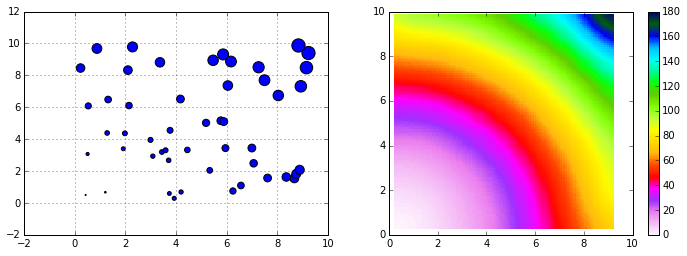

In [99]:
fig = plt.figure(figsize=(12, 4)); ax = fig.gca()
ax1=plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2=plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
ax1.scatter(x, y, z); ax1.grid()
CS = ax2.pcolor(gridx, gridy, out1, cmap=plt.cm.gist_ncar_r, vmin=0,vmax=180); plt.colorbar(CS)

<matplotlib.colorbar.Colorbar instance at 0x0000000039D3E588>

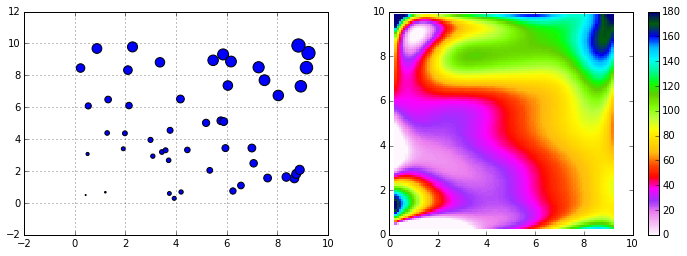

In [100]:
fig = plt.figure(figsize=(12, 4)); ax = fig.gca()
ax1=plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2=plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
ax1.scatter(x, y, z); ax1.grid()
CS = ax2.pcolor(gridx, gridy, out2, cmap=plt.cm.gist_ncar_r, vmin=0,vmax=180); plt.colorbar(CS)